In [27]:
AA_LIST = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] # Alphabetical order

aa_to_idx = {aa: i for i, aa in enumerate(AA_LIST)}
aa_to_idx

{'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'F': 4,
 'G': 5,
 'H': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'P': 12,
 'Q': 13,
 'R': 14,
 'S': 15,
 'T': 16,
 'V': 17,
 'W': 18,
 'Y': 19}

In [2]:
import numpy as np
import torch
from torch_geometric.data import Data
from Bio.PDB import PDBParser, PDBList

# Configuration
PDB_CODE = "1tim"  # Example protein
THRESHOLD = 5.0  # Distance cutoff in Ångströms

# Create residue to index mapping
three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D',
    'CYS': 'C', 'GLN': 'Q', 'GLU': 'E', 'GLY': 'G',
    'HIS': 'H', 'ILE': 'I', 'LEU': 'L', 'LYS': 'K',
    'MET': 'M', 'PHE': 'F', 'PRO': 'P', 'SER': 'S',
    'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}
amino_acids = sorted(three_to_one.values())  # Sorted alphabetically
aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}

def pdb_to_pyg(pdb_code, threshold=5.0):
    # Fetch and parse PDB
    pdbl = PDBList()
    pdb_file = pdbl.retrieve_pdb_file(pdb_code, pdir='.', file_format='pdb')
    structure = PDBParser().get_structure(pdb_code, pdb_file)

    # Process each model separately (NMR structures have multiple models)
    graphs = []
    for model in structure:
        # Extract valid residues and coordinates
        residues = []
        for chain in model:
            for residue in chain:
                if residue.id[0] == ' ' and 'CA' in residue:
                    res_name = residue.resname
                    if res_name in three_to_one:
                        ca_coord = residue['CA'].coord
                        residues.append((res_name, ca_coord))

        # Create one-hot encoded features
        x = []
        for res_name, _ in residues:
            one_letter = three_to_one[res_name]
            idx = aa_to_idx[one_letter]
            one_hot = torch.zeros(len(amino_acids))
            one_hot[idx] = 1.0
            x.append(one_hot)
        x = torch.stack(x)

        # Create edges based on distance
        edge_index = []
        num_res = len(residues)
        coords = np.array([res[1] for res in residues])
        
        # Efficient pairwise distance calculation
        dist_matrix = np.linalg.norm(coords[:, None] - coords[None, :], axis=-1)
        i, j = np.where(dist_matrix < threshold)
        mask = i < j  # Avoid duplicate edges and self-loops
        i, j = i[mask], j[mask]

        # Add both directions for undirected graph
        edge_index = torch.tensor(
            np.concatenate([np.stack([i, j]), np.stack([j, i])], axis=1),
            dtype=torch.long
        )

        # Create PyG graph
        data = Data(x=x, edge_index=edge_index)
        graphs.append(data)

    return graphs

# Generate PyG graphs
protein_graphs = pdb_to_pyg(PDB_CODE, THRESHOLD)
print(f"Generated {len(protein_graphs)} graph(s)")
print("Example graph:", protein_graphs[0])

Structure exists: './pdb1tim.ent' 
Generated 1 graph(s)
Example graph: Data(x=[494, 20], edge_index=[2, 1286])


In [ ]:
protein_graphs[0].x.sum(dim=1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

/tmp/ipykernel_3609/715829662.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


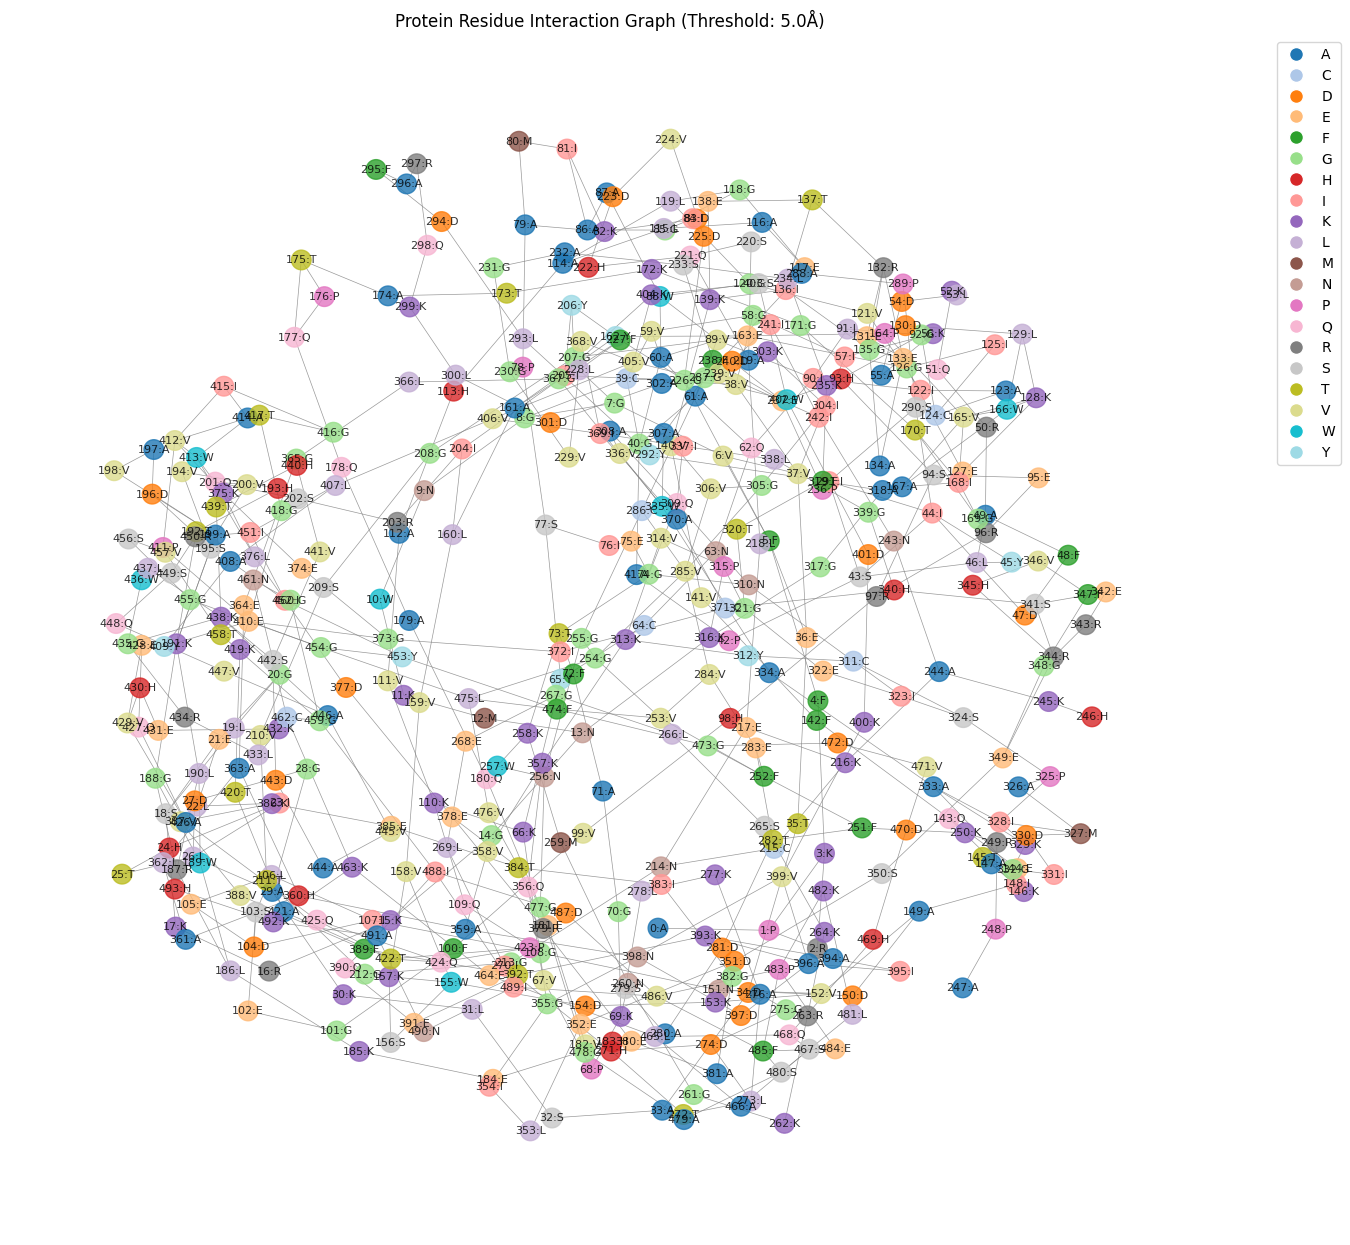

In [26]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx

def visualize_pyg_graph(pyg_data, aa_to_idx, threshold=5.0):
    # Convert to NetworkX graph
    G = to_networkx(pyg_data, node_attrs=['x'], to_undirected=True)
    
    # Reverse the amino acid mapping
    idx_to_aa = {v: k for k, v in aa_to_idx.items()}
    
    # Create node labels and colors
    labels = {}
    node_colors = []
    aa_colors = plt.cm.tab20(np.linspace(0, 1, 20))  # 20 distinct colors
    
    for node_idx, node_data in G.nodes(data=True):
        # Convert node feature to tensor if it isn't already
        one_hot = torch.tensor(node_data['x']) if not isinstance(node_data['x'], torch.Tensor) else node_data['x']
        aa_idx = torch.argmax(one_hot).item()
        aa = idx_to_aa[aa_idx]
        labels[node_idx] = f"{node_idx}:{aa}"
        node_colors.append(aa_colors[aa_idx])
    
    # Draw the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.15, iterations=50)
    
    nx.draw(G, pos, labels=labels, with_labels=True, 
            node_size=200, font_size=8, 
            node_color=node_colors, edge_color='gray', 
            width=0.5, alpha=0.8)
    
    # Create legend for amino acid colors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 label=f"{aa}", markerfacecolor=aa_colors[i], markersize=10)
                      for i, aa in enumerate(aa_to_idx.keys())]
    
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Protein Residue Interaction Graph (Threshold: {threshold}Å)")
    plt.tight_layout()
    plt.show()

# Example usage
visualize_pyg_graph(protein_graphs[0], aa_to_idx, threshold=THRESHOLD)